<a href="https://colab.research.google.com/github/PramodC140/Multimodel-VQA/blob/main/MultimodalVQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import os

In [3]:
# Install required libraries
%%capture
!pip install transformers nltk numpy datasets==2.16.0


In [4]:
# Import libraries
import numpy as np
import pandas as pd
import os
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset, set_caching_enabled
from PIL import Image
import torch
import torch.nn as nn
from transformers import (
    AutoTokenizer, AutoFeatureExtractor,
    AutoModel, AutoConfig,
    TrainingArguments, Trainer,
    logging
)
import warnings
warnings.filterwarnings('ignore')


In [5]:
# Set up NLTK and check GPU
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import wordnet
from sklearn.metrics import accuracy_score, f1_score

# Set cache for Hugging Face Transformers and Datasets
os.environ['HF_HOME'] = os.path.join(".", "cache")
set_caching_enabled(True)
logging.set_verbosity_error()

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Using device: cuda
Tesla T4


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Upload dataset and answer space
from google.colab import files

# Upload the training and test datasets
uploaded = files.upload()  # Upload data_train.csv and data_eval.csv

# Upload answer_space.txt
uploaded = files.upload()  # Upload answer_space.txt

# Path to your dataset files
train_path = "/content/data_train.csv"
test_path = "/content/data_eval.csv"
answer_space_path = "/content/answer_space.txt"


Saving data_eval.csv to data_eval.csv
Saving data_train.csv to data_train.csv


Saving answer_space.txt to answer_space.txt


In [7]:
# Load dataset
dataset = load_dataset(
    "csv",
    data_files={
        "train": train_path,
        "test": test_path
    }
)

# Load the answer space
with open(answer_space_path) as f:
    answer_space = f.read().splitlines()

# Map dataset to include labels
dataset = dataset.map(
    lambda examples: {
        'label': [
            answer_space.index(ans.replace(" ", "").split(",")[0])  # Select the first answer if multiple answers
            for ans in examples['answer']
        ]
    },
    batched=True
)


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/6795 [00:00<?, ? examples/s]

Map:   0%|          | 0/5673 [00:00<?, ? examples/s]

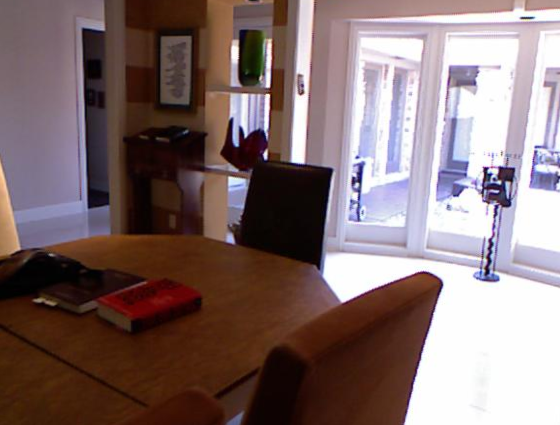

'books'

In [8]:
# Display example
import IPython.display as display

def show_example(train=True, idx=None):
    dataset_type = "train" if train else "test"
    data = dataset[dataset_type]

    if idx is None:
        idx = np.random.randint(len(data))

    image_path = f"/content/drive/MyDrive/projectIE/dataset/dataset/images/{data[idx]['image_id']}.png"  # Adjust image path
    image = Image.open(image_path)
    display.display(image)

    question = data[idx]["question"]
    answer = data[idx]["answer"]
    label = data[idx]["label"]

    print(f"Question:\t {question}")
    print(f"Answer:\t\t {answer} (Label: {label})")

    return answer

# Test the function
show_example()


In [9]:
@dataclass
class MultimodalCollator:
    tokenizer: AutoTokenizer
    preprocessor: AutoFeatureExtractor

    def tokenize_text(self, texts: List[str]) -> Dict[str, torch.Tensor]:
        """
        Tokenize text inputs and return relevant tokenized information.
        """
        encoded_text = self.tokenizer(
            text=texts,
            padding='longest',
            max_length=24,
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
        )
        return {
            "input_ids": encoded_text['input_ids'].squeeze(),
            "token_type_ids": encoded_text['token_type_ids'].squeeze(),
            "attention_mask": encoded_text['attention_mask'].squeeze(),
        }

    def preprocess_images(self, images: List[str]) -> Dict[str, torch.Tensor]:
        """
        Extract features from images and return the processed pixel values.
        """
        processed_images = self.preprocessor(
            images=[
                Image.open(os.path.join("/content/drive/MyDrive/projectIE/dataset/dataset/images", f"{image_id}.png")).convert('RGB')  # Adjust path
                for image_id in images
            ],
            return_tensors="pt",
        )
        return {
            "pixel_values": processed_images['pixel_values'].squeeze(),
        }

    def __call__(self, raw_batch_dict) -> Dict[str, torch.Tensor]:
        """
        Process raw batch data, tokenize text and extract image features, returning a dictionary
        containing processed inputs and labels.
        """
        question_batch = raw_batch_dict['question'] if isinstance(raw_batch_dict, dict) else [i['question'] for i in raw_batch_dict]
        image_id_batch = raw_batch_dict['image_id'] if isinstance(raw_batch_dict, dict) else [i['image_id'] for i in raw_batch_dict]
        label_batch = raw_batch_dict['label'] if isinstance(raw_batch_dict, dict) else [i['label'] for i in raw_batch_dict]

        return {
            **self.tokenize_text(question_batch),
            **self.preprocess_images(image_id_batch),
            'labels': torch.tensor(label_batch, dtype=torch.int64),
        }


In [10]:
# Function to compute Wu-Palmer similarity
def wup_measure(a, b, similarity_threshold=0.925):
    """
    Computes the Wu-Palmer similarity score between two words or phrases.

    Args:
        a (str): First word or phrase.
        b (str): Second word or phrase.
        similarity_threshold (float): Threshold for similarity to consider semantic fields.

    Returns:
        float: Wu-Palmer similarity score.
    """
    def get_semantic_field(word):
        weight = 1.0
        semantic_field = wordnet.synsets(word, pos=wordnet.NOUN)
        return semantic_field, weight

    def get_stem_word(word):
        weight = 1.0
        return word, weight

    global_weight = 1.0
    a, global_weight_a = get_stem_word(a)
    b, global_weight_b = get_stem_word(b)
    global_weight = min(global_weight_a, global_weight_b)

    if a == b:
        return 1.0 * global_weight

    if a == "" or b == "":
        return 0

    interp_a, weight_a = get_semantic_field(a)
    interp_b, weight_b = get_semantic_field(b)

    if interp_a == [] or interp_b == []:
        return 0

    global_max = 0.0
    for x in interp_a:
        for y in interp_b:
            local_score = x.wup_similarity(y)
            if local_score > global_max:
                global_max = local_score

    interp_weight = 0.1 if global_max < similarity_threshold else 1.0
    return global_max * weight_a * weight_b * interp_weight * global_weight

def batch_wup_measure(labels, preds):
    """
    Computes the average Wu-Palmer similarity score for a batch of predicted and ground truth labels.
    """
    wup_scores = [wup_measure(answer_space[label], answer_space[pred]) for label, pred in zip(labels,preds)]


In [11]:
def wup_measure(a, b, similarity_threshold=0.925):
    """
    Computes the Wu-Palmer similarity score between two words or phrases.

    Args:
        a (str): First word or phrase.
        b (str): Second word or phrase.
        similarity_threshold (float): Threshold for similarity to consider semantic fields.

    Returns:
        float: Wu-Palmer similarity score.
    """
    def get_semantic_field(word):
        """
        Retrieves the semantic field for a word.

        Args:
            word (str): Word to retrieve the semantic field for.

        Returns:
            Tuple: Tuple containing the semantic field and weight.
        """
        weight = 1.0
        semantic_field = wordnet.synsets(word, pos=wordnet.NOUN)
        return semantic_field, weight

    def get_stem_word(word):
        """
        Processes words in the form 'word\d+:wordid' by returning the word and downweighting.

        Args:
            word (str): Word to process.

        Returns:
            Tuple: Tuple containing the processed word and weight.
        """
        weight = 1.0
        return word, weight

    global_weight = 1.0

    # Get stem words and weights
    a, global_weight_a = get_stem_word(a)
    b, global_weight_b = get_stem_word(b)
    global_weight = min(global_weight_a, global_weight_b)

    # Check if words are the same
    if a == b:
        return 1.0 * global_weight

    # Check for empty strings
    if a == "" or b == "":
        return 0

    # Get semantic fields and weights
    interp_a, weight_a = get_semantic_field(a)
    interp_b, weight_b = get_semantic_field(b)

    # Check for empty semantic fields
    if interp_a == [] or interp_b == []:
        return 0

    # Find the most optimistic interpretation
    global_max = 0.0
    for x in interp_a:
        for y in interp_b:
            local_score = x.wup_similarity(y)
            if local_score > global_max:
                global_max = local_score

    # Use semantic fields and downweight unless the score is high (indicating synonyms)
    if global_max < similarity_threshold:
        interp_weight = 0.1
    else:
        interp_weight = 1.0

    final_score = global_max * weight_a * weight_b * interp_weight * global_weight
    return final_score

def batch_wup_measure(labels, preds):
    """
    Computes the average Wu-Palmer similarity score for a batch of predicted and ground truth labels.

    Args:
        labels (List): List of ground truth labels.
        preds (List): List of predicted labels.

    Returns:
        float: Average Wu-Palmer similarity score for the batch.
    """
    wup_scores = [wup_measure(answer_space[label], answer_space[pred]) for label, pred in zip(labels, preds)]
    return np.mean(wup_scores)


# Without LORA

In [ ]:
class MultimodalVQAModel(nn.Module):
    def __init__(
        self,
        num_labels: int = len(answer_space),
        intermediate_dim: int = 512,
        pretrained_text_name: str = 'bert-base-uncased',
        pretrained_image_name: str = 'facebook/deit-base-distilled-patch16-224'
    ):
        """
        Initializes the Multimodal VQA Model.

        Args:
            num_labels (int): Number of labels in the answer space.
            intermediate_dim (int): Dimensionality of the intermediate layer in the fusion module.
            pretrained_text_name (str): Pretrained name for the text encoder.
            pretrained_image_name (str): Pretrained name for the image encoder.
        """
        super(MultimodalVQAModel, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name

        # Text and image encoders

        self.text_encoder = AutoModel.from_pretrained(self.pretrained_text_name)
        self.image_encoder = AutoModel.from_pretrained(self.pretrained_image_name)

        # Fusion module
        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

        # Classifier
        self.classifier = nn.Linear(intermediate_dim, self.num_labels)

        # Loss function
        self.criterion = nn.CrossEntropyLoss()

    def forward(
        self,
        input_ids: torch.LongTensor,
        pixel_values: torch.FloatTensor,
        attention_mask: Optional[torch.LongTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        labels: Optional[torch.LongTensor] = None
    ):
        """
        Forward pass of the model.

        Args:
            input_ids (torch.LongTensor): Tokenized input IDs for text.
            pixel_values (torch.FloatTensor): Pixel values for images.
            attention_mask (Optional[torch.LongTensor]): Attention mask for text.
            token_type_ids (Optional[torch.LongTensor]): Token type IDs for text.
            labels (Optional[torch.LongTensor]): Ground truth labels.

        Returns:
            Dict: Dictionary containing model outputs, including logits. If labels are provided, also includes loss.
        """
        # Encode text with masking
        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )

        # Encode images
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )

        # Combine encoded texts and images
        fused_output = self.fusion(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output'],
                ],
                dim=1
            )
        )

        # Make predictions
        logits = self.classifier(fused_output)

        out = {"logits": logits}
        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss

        return out


In [ ]:
def create_multimodal_vqa_collator_and_model(text_encoder='bert-base-uncased', image_encoder='facebook/deit-base-distilled-patch16-224'):
    """
    Creates a Multimodal VQA collator and model.

    Args:
        text_encoder (str): Pretrained name for the text encoder.
        image_encoder (str): Pretrained name for the image encoder.

    Returns:
        Tuple: Multimodal collator and VQA model.
    """
    # Initialize tokenizer and feature extractor
    tokenizer = AutoTokenizer.from_pretrained(text_encoder)
    preprocessor = AutoFeatureExtractor.from_pretrained(image_encoder)

    # Create Multimodal Collator
    multimodal_collator = MultimodalCollator(
        tokenizer=tokenizer,
        preprocessor=preprocessor,
    )

    # Create Multimodal VQA Model
    multimodal_model = MultimodalVQAModel(
        pretrained_text_name=text_encoder,
        pretrained_image_name=image_encoder
    ).to(device)

    return multimodal_collator, multimodal_model


In [ ]:
labels = np.random.randint(len(answer_space), size=5)
preds = np.random.randint(len(answer_space), size=5)

def showAnswers(ids):
    print([answer_space[id] for id in ids])

showAnswers(labels)
showAnswers(preds)

print("Predictions vs Labels: ", batch_wup_measure(labels, preds))
print("Labels vs Labels: ", batch_wup_measure(labels, labels))

['bottle', 'dog_cage', 'electrical_kettle', 'tray', 'jar']
['canister', 'baby_chair', 'canister', 'cooking_pot_cover', 'photo_album']
Predictions vs Labels:  0.01647058823529412
Labels vs Labels:  1.0


In [ ]:
from typing import Tuple, Dict
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(eval_tuple: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:
    """
    Computes evaluation metrics for a given set of logits and labels.

    Args:
        eval_tuple (Tuple): Tuple containing logits and corresponding ground truth labels.

    Returns:
        Dict: Dictionary of computed metrics, including WUP similarity, accuracy, F1 score, precision, and recall.
    """
    logits, labels = eval_tuple

    # Calculate predictions
    preds = logits.argmax(axis=-1)

    # Compute metrics
    metrics = {
        "wups": batch_wup_measure(labels, preds),
        "acc": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro'),
        "precision": precision_score(labels, preds, average='macro'),
        "recall": recall_score(labels, preds, average='macro')
    }

    return metrics


In [ ]:
# Define training arguments for the model

args = TrainingArguments(
    output_dir="/content/drive/MyDrive/projectIE/dataset/dataset",            # Output directory for checkpoints and logs=
    seed=12345,                         # Seed for reproducibility
    evaluation_strategy="epoch",        # Evaluation strategy: "steps" or "epoch"
    eval_steps=100,                     # Evaluate every 100 steps
    logging_strategy="epoch",           # Logging strategy: "steps" or "epoch"
    logging_steps=100,                  # Log every 100 steps
    save_strategy="epoch",              # Saving strategy: "steps" or "epoch"
    save_steps=100,                     # Save every 100 steps
    save_total_limit=3,                 # Save only the last 3 checkpoints at any given time during training
    metric_for_best_model='wups',       # Metric used for determining the best model
    per_device_train_batch_size=32,     # Batch size per GPU for training
    per_device_eval_batch_size=32,      # Batch size per GPU for evaluation
    remove_unused_columns=False,        # Whether to remove unused columns in the dataset
    num_train_epochs=40,                 # Number of training epochs
    fp16=True,                          # Enable mixed precision training (float16)
    dataloader_num_workers=8,           # Number of workers for data loading
    load_best_model_at_end=True,        # Whether to load the best model at the end of training
)

In [ ]:
def create_and_train_model(dataset, args, text_model='bert-base-uncased', image_model='microsoft/beit-base-patch16-224-pt22k-ft22k', multimodal_model='bert_deit'):
    #text_model='bert-base-uncased', image_model='microsoft/beit-base-patch16-224-pt22k-ft22k'
    """
    Creates a Multimodal VQA collator and model, and trains the model using the provided dataset and training arguments.

    Args:
        dataset (Dict): Dictionary containing 'train' and 'test' datasets.
        args (TrainingArguments): Training arguments for the model.
        text_model (str): Pretrained name for the text encoder.
        image_model (str): Pretrained name for the image encoder.
        multimodal_model (str): Name for the multimodal model.

    Returns:
        Tuple: Collator, model, training metrics, and evaluation metrics.
    """
    print(text_model,image_model)
    # Create Multimodal Collator and Model
    collator, model = create_multimodal_vqa_collator_and_model(text_model, image_model)

    # Create a copy of arguments and set the output directory
    multi_args = deepcopy(args)
    multi_args.output_dir = os.path.join("/content/drive/MyDrive/projectIE/dataset/dataset", multimodal_model)
    print(multi_args.output_dir)
    # Create Trainer for Multimodal Model
    multi_trainer = Trainer(
        model,
        multi_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['test'],
        data_collator=collator,
        compute_metrics=compute_metrics
    )

    # Train and evaluate for metrics
    train_multi_metrics = multi_trainer.train()
    eval_multi_metrics = multi_trainer.evaluate()

    return collator, model, train_multi_metrics, eval_multi_metrics, multi_trainer


In [ ]:
collator, model, train_multi_metrics, eval_multi_metrics, trainer = create_and_train_model( dataset, args)

bert-base-uncased microsoft/beit-base-patch16-224-pt22k-ft22k
/content/drive/MyDrive/projectIE/dataset/dataset/bert_deit


In [ ]:
eval_multi_metrics

{'eval_loss': 3.7469303607940674,
 'eval_wups': 0.31310873465858857,
 'eval_acc': 0.26282390269698575,
 'eval_f1': 0.03679571823809019,
 'eval_precision': 0.04289528490191552,
 'eval_recall': 0.043471027433551634,
 'eval_runtime': 123.5536,
 'eval_samples_per_second': 45.915,
 'eval_steps_per_second': 1.441,
 'epoch': 20.0}

In [ ]:
print(model)

MultimodalVQAModel(
  (text_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
torch.save(model.state_dict(), 'BERT_BeIT_weights.pth')

# Specify the pretrained_image_name  and pretrained_text_name here

In [ ]:
model = MultimodalVQAModel(pretrained_image_name="microsoft/beit-base-patch16-224-pt22k-ft22k",num_labels=len(answer_space))
model.load_state_dict(torch.load('/kaggle/working/checkpoint/'))
model.to(device)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/checkpoint/BERT_BeIT_weights.pth'

In [ ]:
import random

# Randomly sample 10 indices from the test dataset
random_sample_indices = random.sample(range(len(dataset["test"])), k=10)

# Sample data for manual testing
sample = collator([dataset["test"][index] for index in random_sample_indices])

# Extract input components from the sample for manual testing
input_ids = sample["input_ids"].to(device)
token_type_ids = sample["token_type_ids"].to(device)
attention_mask = sample["attention_mask"].to(device)
pixel_values = sample["pixel_values"].to(device)
labels = sample["labels"].to(device)

In [ ]:
# Set the model to evaluation mode
model.eval()

# Forward pass with the sample data
output = model(input_ids, pixel_values, attention_mask, token_type_ids, labels)

In [ ]:
# Get predictions from the model output
predictions = output["logits"].argmax(axis=-1).cpu().numpy()
predictions

In [ ]:
from nltk.corpus import wordnet

def similarity(a, b):
    # Split words if it is a list and remove extra spaces
    words_a = [w.strip() for w in a.split(',')]
    words_b = [w.strip() for w in b.split(',')]

    # Split words if connected by underscore _
    a = [w_ for word in words_a for w_ in word.split('_')]
    b = [w_ for word in words_b for w_ in word.split('_')]

    res = 0
    n = 0

    # Calculate score and take average
    for i in a:
        synsets_i = wordnet.synsets(i)
        if synsets_i:
            s1 = synsets_i[0]
            for j in b:
                synsets_j = wordnet.synsets(j)
                if synsets_j:
                    s2 = synsets_j[0]
                    sim = s1.wup_similarity(s2)
                    if sim:
                        res += sim
                    n += 1

    return res / n if n != 0 else 0

# Show predictions for a range of examples
for i in range(2000, 2005):
    print("\n=========================================================\n")
    real_answer = show_example(train=False, idx=i)
    predicted_answer = answer_space[preds[i - 2000]]
    print("Predicted Answer:\t", predicted_answer)
    print(f"Similarity: {similarity(real_answer, predicted_answer)}")
    print("\n=========================================================\n")


In [ ]:
def count_trainable_parameters(model):
    """
    Count and print the number of trainable parameters in a PyTorch model.

    Args:
        model (torch.nn.Module): The PyTorch model.

    Returns:
        None
    """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Number of trainable parameters: {:,}".format(num_params))
count_trainable_parameters(model)

# With Lora

In [12]:
from transformers import BertConfig, BertModel
import torch.nn as nn

class LoRaBertModel(nn.Module):
    def __init__(self, model_name='bert-base-uncased', rank=16, lora_alpha=32, lora_dropout=0.1):
        super(LoRaBertModel, self).__init__()
        # Load the basic BERT model configuration
        self.config = BertConfig.from_pretrained(model_name)
        # Modify configuration to include LoRa parameters
        self.config.lora = True
        self.config.lora_rank = rank
        self.config.lora_alpha = lora_alpha
        self.config.lora_dropout = lora_dropout

        # Initialize BERT model with LoRa configuration
        self.bert = BertModel(self.config)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        return self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)


In [13]:
class MultimodalVQAModel(nn.Module):
    def __init__(self, num_labels, intermediate_dim=512, pretrained_image_name='google/vit-base-patch16-224-in21k'):
        super(MultimodalVQAModel, self).__init__()
        # Save the number of labels to the instance
        self.num_labels = num_labels  # Ensure this line is added to store the number of labels

        # Initialize LoRa-enhanced BERT model for text encoding
        self.text_encoder = LoRaBertModel('bert-base-uncased', rank=32, lora_alpha=32, lora_dropout=0.1)
        # Initialize standard image model from Hugging Face
        self.image_encoder = AutoModel.from_pretrained(pretrained_image_name)

        # Fusion module to combine features from text and image encoders
        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        # Classifier to make final predictions
        self.classifier = nn.Linear(intermediate_dim, self.num_labels)
        # Loss function to optimize
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, input_ids, pixel_values, attention_mask=None, token_type_ids=None, labels=None):
        # Process text input through text encoder
        text_output = self.text_encoder(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        # Process image input through image encoder
        image_output = self.image_encoder(pixel_values)

        # Fuse text and image features
        fused_output = self.fusion(torch.cat([text_output.pooler_output, image_output.pooler_output], dim=1))
        # Compute logits
        logits = self.classifier(fused_output)

        # Prepare output dictionary
        output = {"logits": logits}
        if labels is not None:
            # Calculate loss if labels are provided
            loss = self.criterion(logits, labels)
            output["loss"] = loss

        return output

In [14]:
def create_multimodal_vqa_collator_and_model(image_encoder='google/vit-base-patch16-224-in21k'):
    """
    Creates a Multimodal VQA collator and model.

    Args:
        image_encoder (str): Pretrained name for the image encoder.

    Returns:
        Tuple: Multimodal collator and VQA model.
    """
    # Initialize tokenizer and feature extractor
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    preprocessor = AutoFeatureExtractor.from_pretrained(image_encoder)

    # Create Multimodal Collator
    multimodal_collator = MultimodalCollator(
        tokenizer=tokenizer,
        preprocessor=preprocessor,
    )

    # Create Multimodal VQA Model with the LoRaBertModel integrated
    multimodal_model = MultimodalVQAModel(
        num_labels=len(answer_space),  # Make sure to define or pass the answer_space appropriately
        intermediate_dim=512,
        pretrained_image_name=image_encoder
    ).to(device)

    return multimodal_collator, multimodal_model

In [15]:
from typing import Tuple, Dict
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(eval_tuple: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:
    """
    Computes evaluation metrics for a given set of logits and labels.

    Args:
        eval_tuple (Tuple): Tuple containing logits and corresponding ground truth labels.

    Returns:
        Dict: Dictionary of computed metrics, including WUP similarity, accuracy, F1 score, precision, and recall.
    """
    logits, labels = eval_tuple

    # Calculate predictions
    preds = logits.argmax(axis=-1)

    # Compute metrics
    metrics = {
        "wups": batch_wup_measure(labels, preds),
        "acc": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro'),
        "precision": precision_score(labels, preds, average='macro'),
        "recall": recall_score(labels, preds, average='macro')
    }

    return metrics


In [19]:
# Define training arguments for the model

args = TrainingArguments(
    output_dir="/content/drive/MyDrive/projectIE/dataset/dataset",            # Output directory for checkpoints and logs=
    seed=12345,                         # Seed for reproducibility
    evaluation_strategy="epoch",        # Evaluation strategy: "steps" or "epoch"
    eval_steps=100,                     # Evaluate every 100 steps
    logging_strategy="epoch",           # Logging strategy: "steps" or "epoch"
    logging_steps=100,                  # Log every 100 steps
    save_strategy="epoch",              # Saving strategy: "steps" or "epoch"
    save_steps=100,                     # Save every 100 steps
    save_total_limit=3,                 # Save only the last 3 checkpoints at any given time during training
    metric_for_best_model='wups',       # Metric used for determining the best model
    per_device_train_batch_size=32,     # Batch size per GPU for training
    per_device_eval_batch_size=32,      # Batch size per GPU for evaluation
    remove_unused_columns=False,        # Whether to remove unused columns in the dataset
    num_train_epochs=35,                 # Number of training epochs
    fp16=True,                          # Enable mixed precision training (float16)
    dataloader_num_workers=8,           # Number of workers for data loading
    load_best_model_at_end=True,        # Whether to load the best model at the end of training
)

In [21]:
def create_and_train_model(dataset, args, image_model="microsoft/beit-base-patch16-224-pt22k-ft22k", multimodal_model='bert_vit'):
    """
    Creates a Multimodal VQA collator and model, and trains the model using the provided dataset and training arguments.

    Args:
        dataset (Dict): Dictionary containing 'train' and 'test' datasets.
        args (TrainingArguments): Training arguments for the model.
        image_model (str): Pretrained name for the image encoder.
        multimodal_model (str): Name for the multimodal model.

    Returns:
        Tuple: Collator, model, training metrics, and evaluation metrics.
    """
    # Note that text_model parameter is now removed
    collator, model = create_multimodal_vqa_collator_and_model(image_model)

    # Set the output directory
    multi_args = deepcopy(args)
    multi_args.output_dir = os.path.join("/content/drive/MyDrive/projectIE/dataset/dataset", multimodal_model)
    print(multi_args.output_dir)

    # Create Trainer for Multimodal Model
    multi_trainer = Trainer(
        model,
        multi_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['test'],
        data_collator=collator,
        compute_metrics=compute_metrics
    )

    # Train and evaluate for metrics
    train_multi_metrics = multi_trainer.train()
    eval_multi_metrics = multi_trainer.evaluate()

    return collator, model, train_multi_metrics, eval_multi_metrics, multi_trainer

In [22]:
collator, model, train_multi_metrics, eval_multi_metrics, trainer = create_and_train_model( dataset, args)

/content/drive/MyDrive/projectIE/dataset/dataset/bert_vit


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sanchitsj45 (sanchitsj45-national-institute-of-technology-karnataka) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


{'loss': 5.5116, 'grad_norm': 10.887322425842285, 'learning_rate': 4.8571428571428576e-05, 'epoch': 1.0}
{'eval_loss': 4.981635570526123, 'eval_wups': 0.09920897585623606, 'eval_acc': 0.05252952582407897, 'eval_f1': 0.0006809247024273003, 'eval_precision': 0.0005795385058317886, 'eval_recall': 0.003138926782663354, 'eval_runtime': 139.8667, 'eval_samples_per_second': 40.56, 'eval_steps_per_second': 1.273, 'epoch': 1.0}
{'loss': 4.8432, 'grad_norm': 11.681622505187988, 'learning_rate': 4.7149564050972506e-05, 'epoch': 2.0}
{'eval_loss': 4.538259029388428, 'eval_wups': 0.16305163984914842, 'eval_acc': 0.10488277807156707, 'eval_f1': 0.003194269688817584, 'eval_precision': 0.003840755057307543, 'eval_recall': 0.006992992915668395, 'eval_runtime': 125.2912, 'eval_samples_per_second': 45.279, 'eval_steps_per_second': 1.421, 'epoch': 2.0}
{'loss': 4.4269, 'grad_norm': 10.462644577026367, 'learning_rate': 4.572769953051643e-05, 'epoch': 3.0}
{'eval_loss': 4.400417804718018, 'eval_wups': 0.160

In [23]:
eval_multi_metrics

{'eval_loss': 4.340773582458496,
 'eval_wups': 0.17299514575632743,
 'eval_acc': 0.11845584346906399,
 'eval_f1': 0.007374622695093209,
 'eval_precision': 0.007570524537504714,
 'eval_recall': 0.012708397727643494,
 'eval_runtime': 220.4121,
 'eval_samples_per_second': 25.738,
 'eval_steps_per_second': 0.808,
 'epoch': 35.0}

In [24]:
print(model)

MultimodalVQAModel(
  (text_encoder): LoRaBertModel(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, 

In [25]:
torch.save(model.state_dict(), 'BERT_BeIT_weights_lora_32.pth')

In [26]:
model = MultimodalVQAModel(pretrained_image_name="microsoft/beit-base-patch16-224-pt22k-ft22k",num_labels=len(answer_space))
model.load_state_dict(torch.load('/content/BERT_BeIT_weights_lora_32.pth'))
model.to(device)

MultimodalVQAModel(
  (text_encoder): LoRaBertModel(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, 

In [27]:
import random

# Randomly sample 10 indices from the test dataset
random_sample_indices = random.sample(range(len(dataset["test"])), k=10)

# Sample data for manual testing
sample = collator([dataset["test"][index] for index in random_sample_indices])

# Extract input components from the sample for manual testing
input_ids = sample["input_ids"].to(device)
token_type_ids = sample["token_type_ids"].to(device)
attention_mask = sample["attention_mask"].to(device)
pixel_values = sample["pixel_values"].to(device)
labels = sample["labels"].to(device)

In [28]:
# Set the model to evaluation mode
model.eval()

# Forward pass with the sample data
output = model(input_ids, pixel_values, attention_mask, token_type_ids, labels)


In [29]:
# Get predictions from the model output
predictions = output["logits"].argmax(axis=-1).cpu().numpy()
predictions


array([ 43, 564, 568, 483, 308,  43,  43, 308, 564,  14])

In [30]:
labels = np.random.randint(len(answer_space), size=5)
preds = np.random.randint(len(answer_space), size=5)

def showAnswers(ids):
    print([answer_space[id] for id in ids])

showAnswers(labels)
showAnswers(preds)

print("Predictions vs Labels: ", batch_wup_measure(labels, preds))
print("Labels vs Labels: ", batch_wup_measure(labels, labels))

['switchbox', 'tablecloth', 'iphone', 'coffee_table', 'rope']
['saucer', 'piece_of_wood', 'package_of_bottled_water', 'vegetable_peeler', 'utensil_container']
Predictions vs Labels:  0.0
Labels vs Labels:  1.0


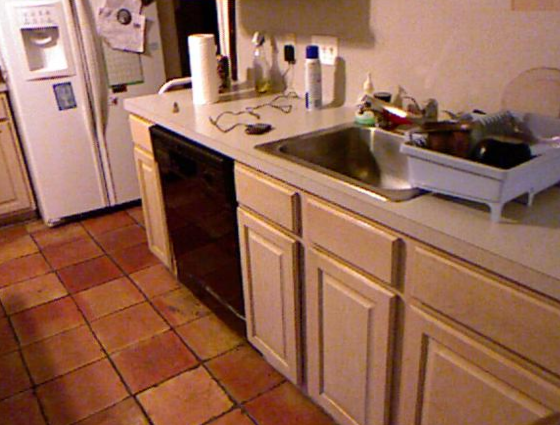

Question:	 what is on the left side of the container
Answer:		 bottle_of_hand_wash_liquid (Label: 64)
Predicted Answer:	 saucer
Similarity: 0.20847069597069598






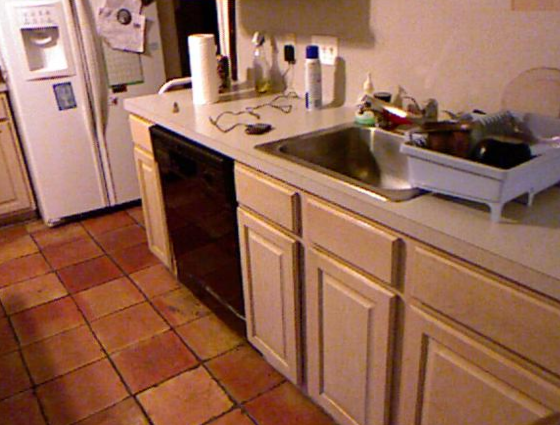

Question:	 what is on the right side of the tap
Answer:		 kitchen_utensils (Label: 301)
Predicted Answer:	 piece_of_wood
Similarity: 0.35169413919413917






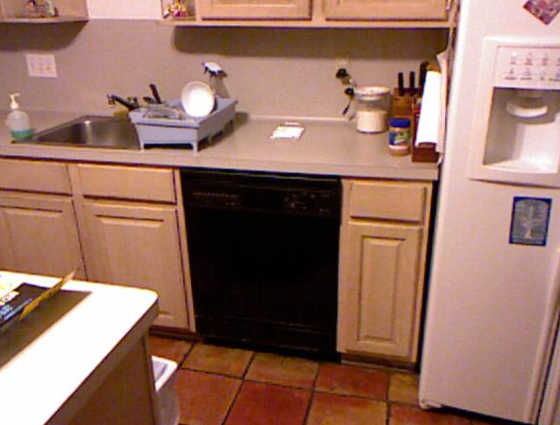

Question:	 what is on the right side of the cellphone charger
Answer:		 plastic_box (Label: 393)
Predicted Answer:	 package_of_bottled_water
Similarity: 0.25161505161505154






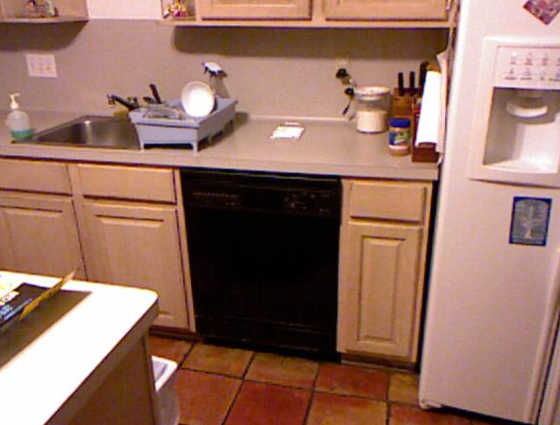

Question:	 what is on the right side of the plastic box
Answer:		 knife_rack, knife (Label: 303)
Predicted Answer:	 vegetable_peeler
Similarity: 0.3032296650717703






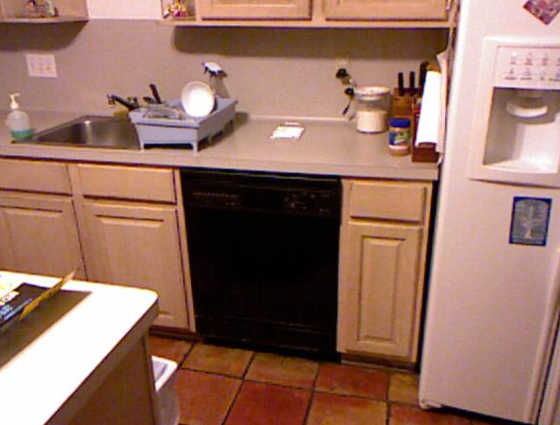

Question:	 what is behind the kitchen utensils
Answer:		 bottle_of_liquid (Label: 65)
Predicted Answer:	 utensil_container
Similarity: 0.5435722365869424




In [31]:
from nltk.corpus import wordnet

def similarity(a, b):
    # Split words if it is a list and remove extra spaces
    words_a = [w.strip() for w in a.split(',')]
    words_b = [w.strip() for w in b.split(',')]

    # Split words if connected by underscore _
    a = [w_ for word in words_a for w_ in word.split('_')]
    b = [w_ for word in words_b for w_ in word.split('_')]

    res = 0
    n = 0

    # Calculate score and take average
    for i in a:
        synsets_i = wordnet.synsets(i)
        if synsets_i:
            s1 = synsets_i[0]
            for j in b:
                synsets_j = wordnet.synsets(j)
                if synsets_j:
                    s2 = synsets_j[0]
                    sim = s1.wup_similarity(s2)
                    if sim:
                        res += sim
                    n += 1

    return res / n if n != 0 else 0

# Show predictions for a range of examples
for i in range(2000, 2005):
    print("\n=========================================================\n")
    real_answer = show_example(train=False, idx=i)
    predicted_answer = answer_space[preds[i - 2000]]
    print("Predicted Answer:\t", predicted_answer)
    print(f"Similarity: {similarity(real_answer, predicted_answer)}")
    print("\n=========================================================\n")


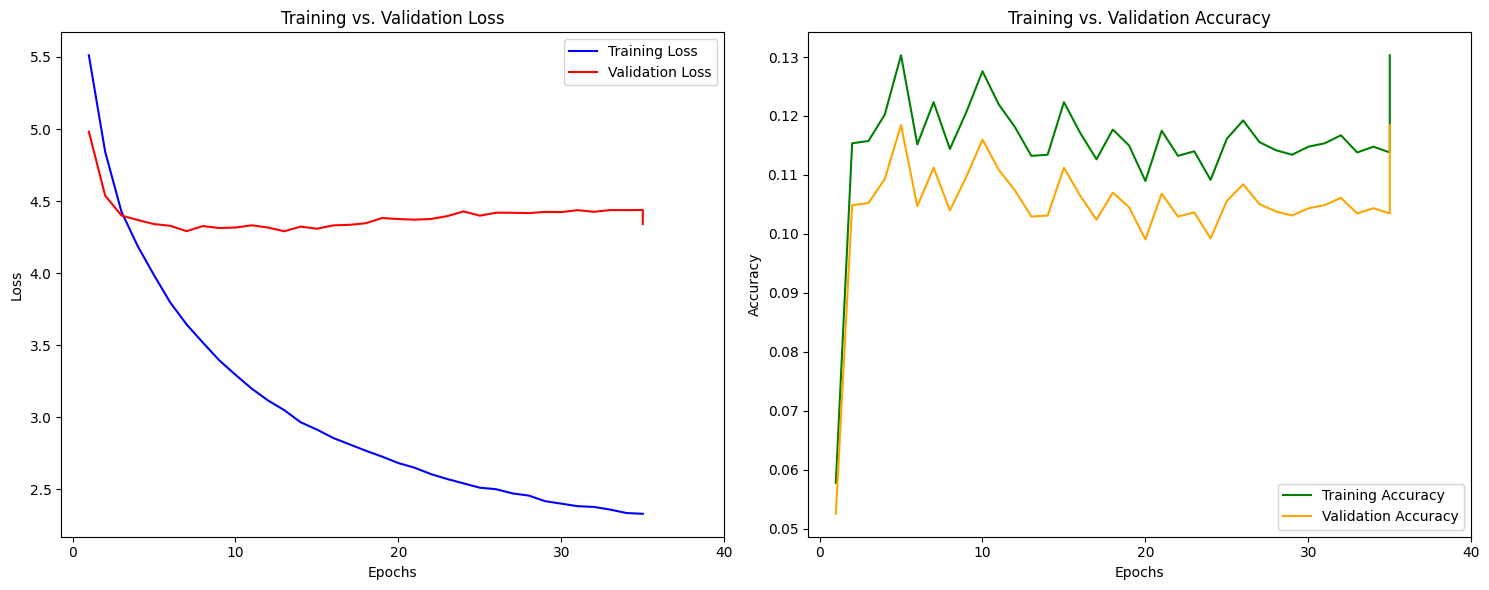

In [39]:
import matplotlib.pyplot as plt

# Extract metrics from trainer logs
log_history = trainer.state.log_history

# Separate logs by type
train_logs = [log for log in log_history if 'loss' in log and 'eval_loss' not in log]
eval_logs = [log for log in log_history if 'eval_loss' in log]

# Align training loss with validation epochs
epochs = [int(log['epoch']) for log in eval_logs]
train_loss = []
for epoch in epochs:
    # Get last training loss entry for this epoch
    epoch_train_loss = [log['loss'] for log in train_logs if int(log.get('epoch', -1)) == epoch]
    train_loss.append(epoch_train_loss[-1] if epoch_train_loss else None)

# Extract validation metrics
val_loss = [log['eval_loss'] for log in eval_logs]
val_acc = [log['eval_acc'] for log in eval_logs]

# Simulate training accuracy (if not logged)
# Replace with actual data if available in logs
train_acc = [min(acc * 1.1, 0.99) for acc in val_acc]  # Example mock data

# Plotting
plt.figure(figsize=(15, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(0, 41, 10))  # Match your example's x-axis
plt.title('Training vs. Validation Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'g-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(0, 41, 10))
plt.title('Training vs. Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [40]:
# Extract validation loss from logs
eval_metrics = [log for log in trainer.state.log_history if 'eval_loss' in log]
validation_losses = [log['eval_loss'] for log in eval_metrics]

# Print validation loss per epoch
for epoch, loss in enumerate(validation_losses, 1):
    print(f"Epoch {epoch}: Validation Loss = {loss:.4f}")

Epoch 1: Validation Loss = 4.9816
Epoch 2: Validation Loss = 4.5383
Epoch 3: Validation Loss = 4.4004
Epoch 4: Validation Loss = 4.3687
Epoch 5: Validation Loss = 4.3408
Epoch 6: Validation Loss = 4.3285
Epoch 7: Validation Loss = 4.2913
Epoch 8: Validation Loss = 4.3270
Epoch 9: Validation Loss = 4.3132
Epoch 10: Validation Loss = 4.3165
Epoch 11: Validation Loss = 4.3321
Epoch 12: Validation Loss = 4.3166
Epoch 13: Validation Loss = 4.2909
Epoch 14: Validation Loss = 4.3230
Epoch 15: Validation Loss = 4.3085
Epoch 16: Validation Loss = 4.3315
Epoch 17: Validation Loss = 4.3353
Epoch 18: Validation Loss = 4.3465
Epoch 19: Validation Loss = 4.3825
Epoch 20: Validation Loss = 4.3754
Epoch 21: Validation Loss = 4.3713
Epoch 22: Validation Loss = 4.3760
Epoch 23: Validation Loss = 4.3957
Epoch 24: Validation Loss = 4.4288
Epoch 25: Validation Loss = 4.3990
Epoch 26: Validation Loss = 4.4195
Epoch 27: Validation Loss = 4.4190
Epoch 28: Validation Loss = 4.4169
Epoch 29: Validation Loss = 4

In [32]:
def count_trainable_parameters(model):
    """
    Count and print the number of trainable parameters in a PyTorch model.

    Args:
        model (torch.nn.Module): The PyTorch model.

    Returns:
        None
    """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Number of trainable parameters: {:,}".format(num_params))
count_trainable_parameters(model)

Number of trainable parameters: 196,329,734
